# <center> Обучение с учителем. Классификация
## <center> Предсказываем отток клиентов из банка
<img src=https://blondeblog.ru/wp-content/uploads/2018/09/2.jpg.jpg>

In [12]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

### Знакомство с данными и их исследование

In [13]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


- RowNumber — номер строки таблицы;
- CustomerId — идентификатор клиента;
- Surname — фамилия клиента;
- CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
- Geography — страна проживания клиента (банк межнациональный);
- Gender — пол клиента;
- Age — возраст клиента;
- Tenure — сколько лет клиент пользуется банком;
- Balance — сколько у клиента денег на счетах в банке;
- NumOfProduct — число услуг банка, которые приобрёл клиент;
- HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);
- IsActiveMember — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);
- EstimatedSalary — предполагаемая заработная плата клиента;
- Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

Проверяем наличие пропусков

In [14]:
churn_data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [15]:
churn_data.describe(include='object')

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


Смотрим на сбалансированность классов:

In [17]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

In [18]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

- BalanceSalaryRatio — отношение баланса на счетах к заработной плате клиента;
- TenureByAge — отношение времени пользования банком к возрасту клиента;
- CreditScoreGivenAge — отношение кредитного рейтинга к возрасту клиента.

In [19]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

In [20]:
#Также перекодируем единственный текстовый категориальный признак Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):

churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


In [21]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

In [22]:
#Проведём нормализацию матрицы наблюдений X:

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [23]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Выполним разбиение, установив значением параметра random_state число 0:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [25]:
#Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

print('Train :', y_train.value_counts(normalize=True))
print('\n')
print('Test :', y_test.value_counts(normalize=True))

Train : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


Test : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


**Задание 4.2
Обучите модель логистической регрессии на тренировочных данных. Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. В качестве значения параметра random_state возьмите 42 для воспроизводимости результатов. Остальные параметры оставьте по умолчанию.
Предскажите метки классов для тренировочной и тестовой выборок.**

In [26]:
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42)
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
print('Train F1: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train F1: 0.49
Test F1: 0.47


**Задание 4.3
Сгенерируйте полиномиальные признаки степени 3 для тренировочной и тестовой выборок. Используйте класс PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.
Чему равно количество признаков в тренировочной выборке?**



In [27]:
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)

poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

print(X_train_poly.shape)

(1881, 454)


**Задание 4.4
Обучите модель логистической регрессии на полиномиальных признаках.
Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. Параметру random_state выставите значение 42 для воспроизводимости результатов. Увеличьте максимальное количество итераций, выделяемых на сходимость (параметр max_iter), до 1000.
Остальные параметры оставьте по умолчанию.
Предскажите метки классов для тренировочной и тестовой выборок.**

In [28]:
log_reg_poly = linear_model.LogisticRegression(solver='sag', max_iter=1000, random_state=42)

log_reg_poly.fit(X_train_poly, y_train)

y_train_pred_poly = log_reg_poly.predict(X_train_poly)
print('Train F1: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_poly)))

y_test_pred_poly = log_reg_poly.predict(X_test_poly)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_poly)))

Train F1: 0.66
Test F1: 0.64


**Задание 4.5
Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. Используйте логистическую регрессию, обученную на полиномиальных признаках из предыдущего задания.
В качестве порога вероятности используйте значения из следующего диапазона:
`thresholds = np.arange(0.1, 1, 0.05)`
Напомним алгоритм, как определить оптимальный порог вероятности:
Предсказать вероятности оттока для каждого клиента из тестовой выборки.
В цикле перебирать значения порогов вероятности threshold: сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0. Далее рассчитать метрику и занести её в заранее созданный список.
Постройте график зависимости целевой метрики от порога вероятности.**

Text(0, 0.5, 'Score')

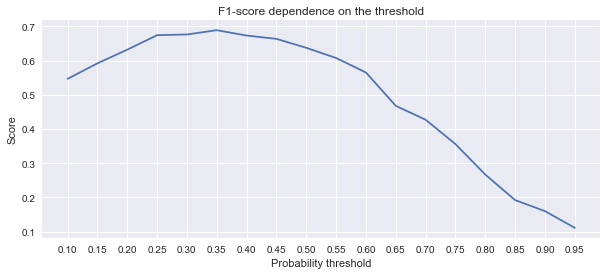

In [29]:
y_test_proba_pred = pd.Series(log_reg_poly.predict_proba(X_test_poly)[:, 1])
f1_scores = []
thresholds = np.arange(0.1, 1, 0.05)
for threshold in thresholds:
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    f1_scores.append(metrics.f1_score(y_test, y_test_pred_poly))
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thresholds, f1_scores, label='F1')
ax.set_title('F1-score dependence on the threshold')
ax.set_xticks(thresholds) 
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')

**Задание 4.6
Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Чему равно значение целевой метрики на тестовой выборке? Ответ приведите с точностью до двух знаков после точки-разделителя.**

In [31]:
threshold_opt = 0.35
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
print('Test F1: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_opt)))

Test F1: 0.69
